# AAI-511 Final Assignment

Name: `Sunil Prasath`

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import librosa
import IPython.display as ipd
from IPython.display import Audio, display, HTML
import mido
import io
import base64
import json
from collections import defaultdict
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [3]:
class MIDIProcessor:
    # Advanced MIDI processing with comprehensive feature extraction
    
    def __init__(self, sample_rate=22050, hop_length=512, n_mels=128):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_mels = n_mels
        
    def midi_to_features(self, midi_path, max_length=5000):
        # Extract comprehensive features from MIDI files
        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            
            # Initialize feature dictionary
            features = {}
            
            # 1. Piano roll representation
            piano_roll = midi_data.get_piano_roll(fs=100)
            if piano_roll.shape[1] == 0:
                return None
                
            # Normalize and resize
            piano_roll = (piano_roll > 0).astype(np.float32)
            
            # 2. Note sequence features
            notes = []
            for instrument in midi_data.instruments:
                if not instrument.is_drum:
                    for note in instrument.notes:
                        notes.append([
                            note.start,
                            note.end,
                            note.pitch,
                            note.velocity
                        ])
            
            if len(notes) == 0:
                return None
                
            notes = np.array(notes)
            
            # 3. Harmonic and rhythmic features
            features.update(self._extract_musical_features(notes, midi_data))
            
            # 4. Sequential note representation for RNN
            note_sequence = self._create_note_sequence(notes, max_length)
            
            # 5. Chord progression features
            chord_features = self._extract_chord_features(midi_data)
            
            return {
                'piano_roll': piano_roll,
                'note_sequence': note_sequence,
                'musical_features': features,
                'chord_features': chord_features
            }
            
        except Exception as e:
            print(f"Error processing {midi_path}: {e}")
            return None
    
    def _extract_musical_features(self, notes, midi_data):
        # Extract advanced musical features
        features = {}
        
        # Pitch statistics
        pitches = notes[:, 2]
        features['pitch_mean'] = np.mean(pitches)
        features['pitch_std'] = np.std(pitches)
        features['pitch_range'] = np.max(pitches) - np.min(pitches)
        features['pitch_median'] = np.median(pitches)
        
        # Velocity statistics
        velocities = notes[:, 3]
        features['velocity_mean'] = np.mean(velocities)
        features['velocity_std'] = np.std(velocities)
        
        # Duration statistics
        durations = notes[:, 1] - notes[:, 0]
        features['duration_mean'] = np.mean(durations)
        features['duration_std'] = np.std(durations)
        
        # Interval analysis
        pitch_intervals = np.diff(sorted(pitches))
        if len(pitch_intervals) > 0:
            features['interval_mean'] = np.mean(pitch_intervals)
            features['interval_std'] = np.std(pitch_intervals)
        else:
            features['interval_mean'] = 0
            features['interval_std'] = 0
        
        # Tempo and rhythm
        features['total_time'] = midi_data.get_end_time()
        features['note_density'] = len(notes) / features['total_time'] if features['total_time'] > 0 else 0
        
        # Pitch class distribution
        pitch_classes = pitches % 12
        pitch_class_hist = np.histogram(pitch_classes, bins=12, range=(0, 12))[0]
        features.update({f'pitch_class_{i}': pitch_class_hist[i] for i in range(12)})
        
        return features
    
    def _create_note_sequence(self, notes, max_length):
        # Create sequential representation of notes
        # Sort notes by start time
        sorted_notes = notes[np.argsort(notes[:, 0])]
        
        # Create sequence with pitch, duration, and velocity
        sequence = []
        for note in sorted_notes:
            duration = note[1] - note[0]
            sequence.append([note[2], duration, note[3]])  # pitch, duration, velocity
        
        # Pad or truncate to max_length
        sequence = np.array(sequence)
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        elif len(sequence) < max_length:
            padding = np.zeros((max_length - len(sequence), 3))
            sequence = np.vstack([sequence, padding])
            
        return sequence.astype(np.float32)
    
    def _extract_chord_features(self, midi_data):
        # Extract chord progression features
        # Get chroma features
        piano_roll = midi_data.get_piano_roll(fs=100)
        if piano_roll.shape[1] == 0:
            return np.zeros(12)
            
        # Calculate chroma vector
        chroma = np.zeros(12)
        for pitch in range(piano_roll.shape[0]):
            chroma[pitch % 12] += np.sum(piano_roll[pitch, :])
            
        # Normalize
        if np.sum(chroma) > 0:
            chroma = chroma / np.sum(chroma)
            
        return chroma

In [4]:
class MIDIDataset(Dataset):
     # Enhanced dataset class with data augmentation
    
    def __init__(self, data_dir, split='train', transform=None, augment=True):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.augment = augment and (split == 'train')
        
        self.processor = MIDIProcessor()
        self.label_encoder = LabelEncoder()
        
        self.samples = []
        self.labels = []
        
        self._load_data()
        
    def _load_data(self):
        # Load and process MIDI files
        split_dir = os.path.join(self.data_dir, self.split)
        composers = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        
        print(f"Loading {self.split} data...")
        for composer in tqdm(composers):
            composer_dir = os.path.join(split_dir, composer)
            midi_files = [f for f in os.listdir(composer_dir) if f.endswith('.mid')]
            
            for midi_file in midi_files:
                midi_path = os.path.join(composer_dir, midi_file)
                features = self.processor.midi_to_features(midi_path)
                
                if features is not None:
                    self.samples.append(features)
                    self.labels.append(composer)
                    
                    # Data augmentation for training set
                    if self.augment:
                        # Create augmented versions
                        aug_features = self._augment_features(features)
                        for aug_feat in aug_features:
                            self.samples.append(aug_feat)
                            self.labels.append(composer)
        
        # Encode labels
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.num_classes = len(self.label_encoder.classes_)
        
        print(f"Loaded {len(self.samples)} samples from {self.num_classes} composers")
        
    def _augment_features(self, features):
        # Apply data augmentation techniques
        augmented = []
        
        # Pitch shifting
        for shift in [-2, -1, 1, 2]:
            aug_features = features.copy()
            aug_features['note_sequence'] = features['note_sequence'].copy()
            aug_features['note_sequence'][:, 0] += shift  # Shift pitch
            aug_features['note_sequence'][:, 0] = np.clip(aug_features['note_sequence'][:, 0], 0, 127)
            augmented.append(aug_features)
            
        # Time stretching
        for stretch in [0.9, 1.1]:
            aug_features = features.copy()
            aug_features['note_sequence'] = features['note_sequence'].copy()
            aug_features['note_sequence'][:, 1] *= stretch  # Stretch duration
            augmented.append(aug_features)
        
        return augmented
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        # Prepare features for model
        note_sequence = torch.FloatTensor(sample['note_sequence'])
        
        # Musical features vector
        musical_features = list(sample['musical_features'].values())
        musical_features = torch.FloatTensor(musical_features)
        
        # Chord features
        chord_features = torch.FloatTensor(sample['chord_features'])
        
        return {
            'note_sequence': note_sequence,
            'musical_features': musical_features,
            'chord_features': chord_features,
            'label': torch.LongTensor([label])
        }

In [5]:
class ComposerClassifierModel(nn.Module):
    # Hybrid CNN-LSTM model with attention mechanism
    
    def __init__(self, num_classes, sequence_length=5000, musical_feature_dim=50, 
                 hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        
        # CNN for local pattern extraction
        self.conv1 = nn.Conv1d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(dropout)
        
        # LSTM for sequential modeling
        self.lstm = nn.LSTM(512, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=16, dropout=dropout)
        
        # Musical features processing
        self.musical_fc = nn.Sequential(
            nn.Linear(musical_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64)
        )
        
        # Chord features processing
        self.chord_fc = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 64 + 32, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
    def forward(self, note_sequence, musical_features, chord_features):
        batch_size = note_sequence.size(0)
        
        # CNN processing
        x = note_sequence.transpose(1, 2)  # (batch, features, sequence)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        
        # Prepare for LSTM
        x = x.transpose(1, 2)  # (batch, sequence, features)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out)
        
        # Attention mechanism
        lstm_out_transposed = lstm_out.transpose(0, 1)  # (sequence, batch, features)
        attended, _ = self.attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)
        attended = attended.transpose(0, 1)  # (batch, sequence, features)
        
        # Global average pooling
        sequence_features = torch.mean(attended, dim=1)
        
        # Process musical features
        musical_out = self.musical_fc(musical_features)
        
        # Process chord features
        chord_out = self.chord_fc(chord_features)
        
        # Concatenate all features
        combined = torch.cat([sequence_features, musical_out, chord_out], dim=1)
        
        # Final classification
        output = self.classifier(combined)
        
        return output

In [6]:
class MIDITrainer:
    # Advanced trainer with various optimizations
    
    def __init__(self, model, device, num_classes):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50)
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in tqdm(dataloader, desc="Training"):
            self.optimizer.zero_grad()
            
            # Move data to device
            note_seq = batch['note_sequence'].to(self.device)
            musical_feat = batch['musical_features'].to(self.device)
            chord_feat = batch['chord_features'].to(self.device)
            labels = batch['label'].squeeze().to(self.device)
            
            # Forward pass
            outputs = self.model(note_seq, musical_feat, chord_feat)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        
        return avg_loss, accuracy
    
    def validate(self, dataloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validating"):
                note_seq = batch['note_sequence'].to(self.device)
                musical_feat = batch['musical_features'].to(self.device)
                chord_feat = batch['chord_features'].to(self.device)
                labels = batch['label'].squeeze().to(self.device)
                
                outputs = self.model(note_seq, musical_feat, chord_feat)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        
        return avg_loss, accuracy, all_predictions, all_labels
    
    def train(self, train_loader, val_loader, epochs=50, patience=10):
        best_val_acc = 0
        patience_counter = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_acc, _, _ = self.validate(val_loader)
            
            # Scheduler step
            self.scheduler.step()
            
            # Record metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {self.scheduler.get_last_lr()[0]:.6f}")
            
            # Early stopping and model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'val_acc': val_acc,
                }, 'best_model.pth')
                print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break
        
        return best_val_acc

In [7]:
class MIDIPlayerWidget:
    # Enhanced MIDI playback widget for Jupyter notebooks
    
    def __init__(self):
        self.current_audio = None
        
    def midi_to_audio(self, midi_path, sf2_path=None):
        # Convert MIDI to audio for playback
        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            
            # Synthesize audio
            if sf2_path and os.path.exists(sf2_path):
                audio = midi_data.fluidsynth(sf2_path=sf2_path)
            else:
                # Use default synthesis
                audio = midi_data.synthesize()
            
            return audio, 22050  # Return audio and sample rate
            
        except Exception as e:
            print(f"Error converting MIDI to audio: {e}")
            return None, None
    
    def create_player_widget(self, midi_path, composer_name=None):
        # Create an interactive player widget
        audio, sr = self.midi_to_audio(midi_path)
        
        if audio is None:
            return HTML("<p>Could not load MIDI file for playback</p>")
        
        # Create audio widget
        title = f"<h4>🎵 {composer_name if composer_name else 'MIDI File'}</h4>"
        audio_widget = Audio(audio, rate=sr, autoplay=False)
        
        # Display both
        display(HTML(title))
        return audio_widget
    
    def create_prediction_widget(self, midi_path, predicted_composer, confidence, actual_composer=None):
        # Create widget showing prediction results with playback
        audio, sr = self.midi_to_audio(midi_path)
        
        html_content = f"""
        <div style="border: 2px solid #4CAF50; padding: 15px; margin: 10px 0; border-radius: 10px;">
            <h3>🎼 Composer Prediction Results</h3>
            <p><strong>Predicted Composer:</strong> <span style="color: #2E8B57; font-size: 18px;">{predicted_composer}</span></p>
            <p><strong>Confidence:</strong> {confidence:.2%}</p>
            {f'<p><strong>Actual Composer:</strong> {actual_composer}</p>' if actual_composer else ''}
            {f'<p><strong>Prediction:</strong> <span style="color: {"green" if actual_composer == predicted_composer else "red"};">{"✓ Correct" if actual_composer == predicted_composer else "✗ Incorrect"}</span></p>' if actual_composer else ''}
        </div>
        """
        
        display(HTML(html_content))
        
        if audio is not None:
            return Audio(audio, rate=sr, autoplay=False)
        else:
            return HTML("<p>Audio playback not available</p>")

In [8]:
def collate_fn(batch):
    # Custom collate function for DataLoader
    note_sequences = [item['note_sequence'] for item in batch]
    musical_features = torch.stack([item['musical_features'] for item in batch])
    chord_features = torch.stack([item['chord_features'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    # Pad note sequences to same length
    note_sequences = pad_sequence(note_sequences, batch_first=True, padding_value=0)
    
    return {
        'note_sequence': note_sequences,
        'musical_features': musical_features,
        'chord_features': chord_features,
        'label': labels
    }

In [9]:
def plot_training_history(trainer):
    # Plot training metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    epochs = range(1, len(trainer.train_losses) + 1)
    ax1.plot(epochs, trainer.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plots
    ax2.plot(epochs, trainer.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, trainer.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate
    if hasattr(trainer.scheduler, 'get_last_lr'):
        lrs = [trainer.scheduler.get_last_lr()[0] for _ in epochs]
        ax3.plot(epochs, lrs, 'g-')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True)
    
    # Best metrics summary
    best_train_acc = max(trainer.train_accuracies)
    best_val_acc = max(trainer.val_accuracies)
    ax4.bar(['Best Train Acc', 'Best Val Acc'], [best_train_acc, best_val_acc], 
            color=['blue', 'red'], alpha=0.7)
    ax4.set_title('Best Accuracies')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_ylim(0, 100)
    
    for i, v in enumerate([best_train_acc, best_val_acc]):
        ax4.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [10]:
def evaluate_model(model, test_loader, device, label_encoder):
    # Comprehensive model evaluation
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            note_seq = batch['note_sequence'].to(device)
            musical_feat = batch['musical_features'].to(device)
            chord_feat = batch['chord_features'].to(device)
            labels = batch['label'].squeeze().to(device)
            
            outputs = model(note_seq, musical_feat, chord_feat)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'probabilities': all_probabilities
    }

In [11]:
def run_composer_classification_pipeline():
    # Main pipeline execution
    
    # Configuration
    DATA_DIR = "NN_midi_files_extended"
    BATCH_SIZE = 16
    EPOCHS = 50
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {DEVICE}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = MIDIDataset(DATA_DIR, split='train', augment=True)
    val_dataset = MIDIDataset(DATA_DIR, split='dev', augment=False)
    test_dataset = MIDIDataset(DATA_DIR, split='test', augment=False)
    
    # Update label encoders to be consistent
    val_dataset.label_encoder = train_dataset.label_encoder
    test_dataset.label_encoder = train_dataset.label_encoder
    val_dataset.num_classes = train_dataset.num_classes
    test_dataset.num_classes = train_dataset.num_classes
    
    # Create data loaders with weighted sampling for imbalanced data
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                             shuffle=True, collate_fn=collate_fn, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                           shuffle=False, collate_fn=collate_fn, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                            shuffle=False, collate_fn=collate_fn, num_workers=2)
    
    # Create model
    model = ComposerClassifierModel(
        num_classes=train_dataset.num_classes,
        sequence_length=5000,
        musical_feature_dim=len(train_dataset[0]['musical_features']),
        hidden_dim=128,
        num_layers=2, # Changed
        dropout=0.3
    ).to(DEVICE)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Create trainer
    trainer = MIDITrainer(model, DEVICE, train_dataset.num_classes)
    
    # Train model
    print("Starting training...")
    best_val_acc = trainer.train(train_loader, val_loader, epochs=EPOCHS)
    
    # Plot training history
    plot_training_history(trainer)
    
    # Load best model for testing
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_results = evaluate_model(model, test_loader, DEVICE, train_dataset.label_encoder)
    
    # Create player widget for demonstration
    player = MIDIPlayerWidget()
    
    return {
        'model': model,
        'trainer': trainer,
        'datasets': {'train': train_dataset, 'val': val_dataset, 'test': test_dataset},
        'test_results': test_results,
        'player': player,
        'label_encoder': train_dataset.label_encoder
    }


In [12]:
def predict_composer(model, midi_path, label_encoder, device, player_widget=None):
    # Predict composer for a single MIDI file
    processor = MIDIProcessor()
    features = processor.midi_to_features(midi_path)
    
    if features is None:
        print("Could not process MIDI file")
        return None
    
    model.eval()
    with torch.no_grad():
        # Prepare features
        note_sequence = torch.FloatTensor(features['note_sequence']).unsqueeze(0).to(device)
        musical_features = torch.FloatTensor(list(features['musical_features'].values())).unsqueeze(0).to(device)
        chord_features = torch.FloatTensor(features['chord_features']).unsqueeze(0).to(device)
        
        # Make prediction
        outputs = model(note_sequence, musical_features, chord_features)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        predicted_composer = label_encoder.inverse_transform([predicted.item()])[0]
        confidence_score = confidence.item()
        
        # Display results with player widget
        if player_widget:
            return player_widget.create_prediction_widget(
                midi_path, predicted_composer, confidence_score
            )
        
        return predicted_composer, confidence_score


In [13]:
def analyze_composer_characteristics(model, datasets, label_encoder, device):
    # Analyze what the model learned about different composers
    model.eval()
    
    composer_features = defaultdict(list)
    
    # Collect features for each composer
    for dataset_name, dataset in datasets.items():
        if dataset_name == 'train':  # Use training data for analysis
            for i in range(len(dataset)):
                sample = dataset[i]
                composer_idx = sample['label'].item()
                composer = label_encoder.inverse_transform([composer_idx])[0]
                
                # Store musical features
                composer_features[composer].append(sample['musical_features'].numpy())
    
    # Calculate average features per composer
    composer_profiles = {}
    for composer, features_list in composer_features.items():
        features_array = np.array(features_list)
        composer_profiles[composer] = {
            'mean_features': np.mean(features_array, axis=0),
            'std_features': np.std(features_array, axis=0),
            'num_samples': len(features_list)
        }
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Feature names (corresponding to the musical features extracted)
    feature_names = [
        'pitch_mean', 'pitch_std', 'pitch_range', 'pitch_median',
        'velocity_mean', 'velocity_std', 'duration_mean', 'duration_std',
        'interval_mean', 'interval_std', 'total_time', 'note_density'
    ] + [f'pitch_class_{i}' for i in range(12)]
    
    # Select most discriminative features for visualization
    selected_features = ['pitch_mean', 'pitch_std', 'velocity_mean', 'note_density', 
                        'duration_mean', 'pitch_range']
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected_features]
    
    # Create radar chart for composer characteristics
    composers = list(composer_profiles.keys())
    num_composers = len(composers)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(selected_features):
        if i < len(axes):
            feature_idx = selected_indices[i]
            values = [composer_profiles[comp]['mean_features'][feature_idx] for comp in composers]
            
            axes[i].bar(composers, values, alpha=0.7, color=plt.cm.Set3(np.linspace(0, 1, num_composers)))
            axes[i].set_title(f'{feature_name.replace("_", " ").title()}')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Composer Musical Characteristics Analysis', fontsize=16, y=1.02)
    plt.show()
    
    return composer_profiles

In [15]:
def save_model_and_results(results, save_path="composer_classifier_results"):
    # Save complete model and results
    os.makedirs(save_path, exist_ok=True)
    
    # Save model
    torch.save({
        'model_state_dict': results['model'].state_dict(),
        'label_encoder': results['label_encoder'],
        'test_results': results['test_results'],
        'model_config': {
            'num_classes': len(results['label_encoder'].classes_),
            'sequence_length': 5000,
            'musical_feature_dim': len(results['datasets']['train'][0]['musical_features']),
            'hidden_dim': 256,
            'num_layers': 2,
            'dropout': 0.3
        }
    }, os.path.join(save_path, 'complete_model.pth'))
    
    # Save training history
    history_data = {
        'train_losses': results['trainer'].train_losses,
        'val_losses': results['trainer'].val_losses,
        'train_accuracies': results['trainer'].train_accuracies,
        'val_accuracies': results['trainer'].val_accuracies
    }
    
    with open(os.path.join(save_path, 'training_history.json'), 'w') as f:
        json.dump(history_data, f, indent=2)
    
    # Save composer classes
    with open(os.path.join(save_path, 'composer_classes.json'), 'w') as f:
        json.dump(results['label_encoder'].classes_.tolist(), f, indent=2)
    
    print(f"Model and results saved to {save_path}/")

In [16]:
def load_saved_model(save_path, device):
    # Load previously saved model
    checkpoint = torch.load(os.path.join(save_path, 'complete_model.pth'), map_location=device)
    
    # Recreate model
    model = ComposerClassifierModel(**checkpoint['model_config']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['label_encoder'], checkpoint['test_results']

In [17]:
def run_quick_demo():
    # Quick demonstration of the system
    print("🎼 MIDI Composer Classification System - Quick Demo")
    print("=" * 60)
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Display interface
    display(create_demo_interface())
    
    # Instructions for full usage
    print("\n📋 To run the complete system:")
    print("1. Ensure your dataset is in 'NN_midi_files_extended' directory")
    print("2. Run: results = run_composer_classification_pipeline()")
    print("3. Use the returned components for prediction and analysis")
    
    return device

In [18]:
def batch_predict_directory(model, directory_path, label_encoder, device, player_widget=None):
    # Predict composers for all MIDI files in a directory
    results = []
    
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.mid'):
                midi_path = os.path.join(root, file)
                try:
                    prediction = predict_composer(model, midi_path, label_encoder, device)
                    if prediction:
                        composer, confidence = prediction
                        results.append({
                            'file': file,
                            'path': midi_path,
                            'predicted_composer': composer,
                            'confidence': confidence
                        })
                except Exception as e:
                    print(f"Error processing {file}: {e}")
    
    # Create results DataFrame
    df_results = pd.DataFrame(results)
    
    if len(df_results) > 0:
        # Display summary
        print(f"\nProcessed {len(df_results)} MIDI files")
        print("\nPrediction Summary:")
        print(df_results.groupby('predicted_composer').agg({
            'confidence': ['count', 'mean', 'std']
        }).round(3))
        
        # Plot confidence distribution
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        df_results['confidence'].hist(bins=20, alpha=0.7, edgecolor='black')
        plt.title('Confidence Score Distribution')
        plt.xlabel('Confidence')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        composer_counts = df_results['predicted_composer'].value_counts()
        plt.pie(composer_counts.values, labels=composer_counts.index, autopct='%1.1f%%')
        plt.title('Predicted Composer Distribution')
        
        plt.tight_layout()
        plt.show()
    
    return df_results

Using device: cuda
CUDA available: True
Creating datasets...
Loading train data...


100%|██████████████████████████████████████████████████████████| 9/9 [02:42<00:00, 18.03s/it]


Loaded 2653 samples from 9 composers
Loading dev data...


100%|██████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.29s/it]


Loaded 35 samples from 9 composers
Loading test data...


100%|██████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]


Loaded 35 samples from 9 composers
Model created with 2724073 parameters
Starting training...

Epoch 1/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.86it/s]


Train Loss: 2.9129, Train Acc: 31.21%
Val Loss: 1.7215, Val Acc: 40.00%
Learning Rate: 0.000999
New best model saved with validation accuracy: 40.00%

Epoch 2/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Train Loss: 1.7263, Train Acc: 47.61%
Val Loss: 1.8419, Val Acc: 42.86%
Learning Rate: 0.000996
New best model saved with validation accuracy: 42.86%

Epoch 3/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.07it/s]


Train Loss: 1.5617, Train Acc: 55.86%
Val Loss: 1.5055, Val Acc: 48.57%
Learning Rate: 0.000991
New best model saved with validation accuracy: 48.57%

Epoch 4/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.12it/s]


Train Loss: 1.3524, Train Acc: 63.74%
Val Loss: 1.7693, Val Acc: 45.71%
Learning Rate: 0.000984

Epoch 5/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.93it/s]


Train Loss: 1.2503, Train Acc: 69.85%
Val Loss: 1.6648, Val Acc: 51.43%
Learning Rate: 0.000976
New best model saved with validation accuracy: 51.43%

Epoch 6/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.07it/s]


Train Loss: 1.1505, Train Acc: 74.71%
Val Loss: 2.0940, Val Acc: 40.00%
Learning Rate: 0.000965

Epoch 7/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.12it/s]


Train Loss: 1.0623, Train Acc: 77.76%
Val Loss: 1.6895, Val Acc: 42.86%
Learning Rate: 0.000952

Epoch 8/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.13it/s]


Train Loss: 1.0303, Train Acc: 79.49%
Val Loss: 1.6902, Val Acc: 48.57%
Learning Rate: 0.000938

Epoch 9/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.29it/s]


Train Loss: 0.9311, Train Acc: 84.43%
Val Loss: 1.7198, Val Acc: 51.43%
Learning Rate: 0.000922

Epoch 10/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.04it/s]


Train Loss: 0.8978, Train Acc: 86.47%
Val Loss: 1.9550, Val Acc: 48.57%
Learning Rate: 0.000905

Epoch 11/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.09it/s]


Train Loss: 0.8827, Train Acc: 86.81%
Val Loss: 1.8574, Val Acc: 48.57%
Learning Rate: 0.000885

Epoch 12/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Train Loss: 0.8266, Train Acc: 89.03%
Val Loss: 1.7172, Val Acc: 60.00%
Learning Rate: 0.000864
New best model saved with validation accuracy: 60.00%

Epoch 13/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.30it/s]


Train Loss: 0.8074, Train Acc: 90.84%
Val Loss: 2.1482, Val Acc: 57.14%
Learning Rate: 0.000842

Epoch 14/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.25it/s]


Train Loss: 0.7757, Train Acc: 91.52%
Val Loss: 2.0370, Val Acc: 51.43%
Learning Rate: 0.000819

Epoch 15/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Train Loss: 0.7717, Train Acc: 92.05%
Val Loss: 1.7799, Val Acc: 57.14%
Learning Rate: 0.000794

Epoch 16/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.28it/s]


Train Loss: 0.7520, Train Acc: 92.69%
Val Loss: 1.6339, Val Acc: 62.86%
Learning Rate: 0.000768
New best model saved with validation accuracy: 62.86%

Epoch 17/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Train Loss: 0.7427, Train Acc: 93.29%
Val Loss: 1.7033, Val Acc: 65.71%
Learning Rate: 0.000741
New best model saved with validation accuracy: 65.71%

Epoch 18/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.52it/s]


Train Loss: 0.7132, Train Acc: 94.61%
Val Loss: 1.5322, Val Acc: 60.00%
Learning Rate: 0.000713

Epoch 19/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.04it/s]


Train Loss: 0.6998, Train Acc: 95.06%
Val Loss: 2.0016, Val Acc: 51.43%
Learning Rate: 0.000684

Epoch 20/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.56it/s]


Train Loss: 0.6945, Train Acc: 95.25%
Val Loss: 1.9640, Val Acc: 65.71%
Learning Rate: 0.000655

Epoch 21/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.11it/s]


Train Loss: 0.6802, Train Acc: 95.74%
Val Loss: 1.6661, Val Acc: 60.00%
Learning Rate: 0.000624

Epoch 22/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.17it/s]


Train Loss: 0.6772, Train Acc: 95.51%
Val Loss: 2.0406, Val Acc: 62.86%
Learning Rate: 0.000594

Epoch 23/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.75it/s]


Train Loss: 0.6462, Train Acc: 97.17%
Val Loss: 2.0501, Val Acc: 60.00%
Learning Rate: 0.000563

Epoch 24/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Train Loss: 0.6472, Train Acc: 96.98%
Val Loss: 1.9769, Val Acc: 62.86%
Learning Rate: 0.000531

Epoch 25/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.07it/s]


Train Loss: 0.6352, Train Acc: 97.14%
Val Loss: 1.9426, Val Acc: 62.86%
Learning Rate: 0.000500

Epoch 26/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  8.52it/s]


Train Loss: 0.6218, Train Acc: 97.44%
Val Loss: 1.7068, Val Acc: 62.86%
Learning Rate: 0.000469

Epoch 27/50


Validating: 100%|██████████████████████████████████████████████| 3/3 [00:00<00:00,  7.93it/s]


Train Loss: 0.6155, Train Acc: 97.78%
Val Loss: 1.6280, Val Acc: 62.86%
Learning Rate: 0.000437
Early stopping triggered after 10 epochs without improvement


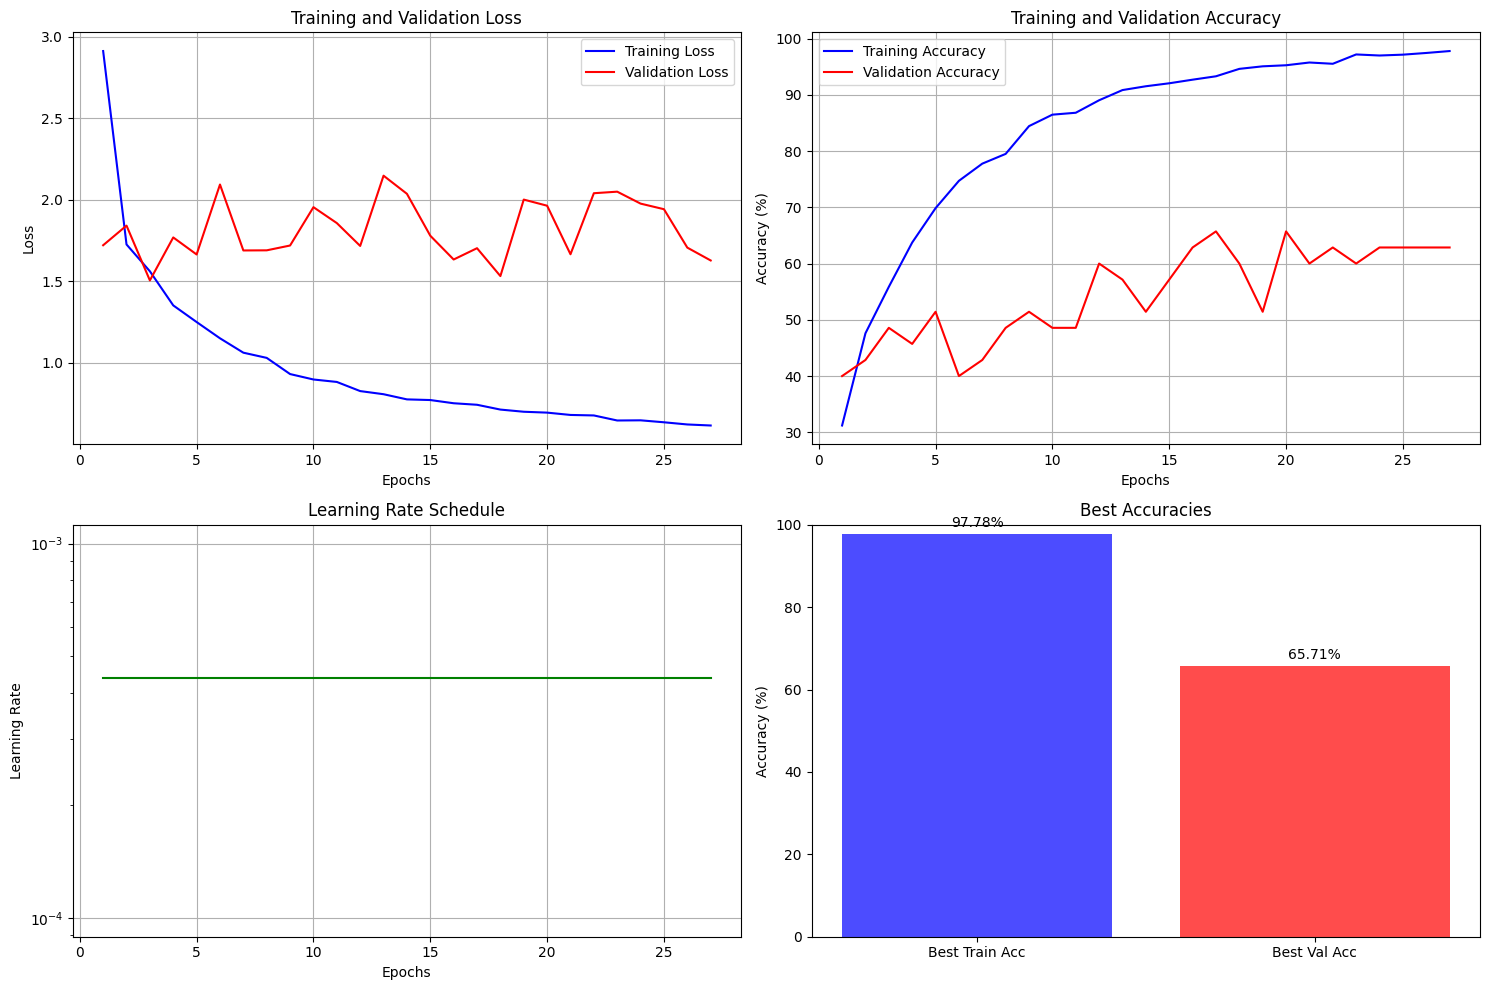

Evaluating on test set...


Testing: 100%|█████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.84it/s]


Test Accuracy: 0.8571
Precision: 0.8871
Recall: 0.8571
F1-Score: 0.8535


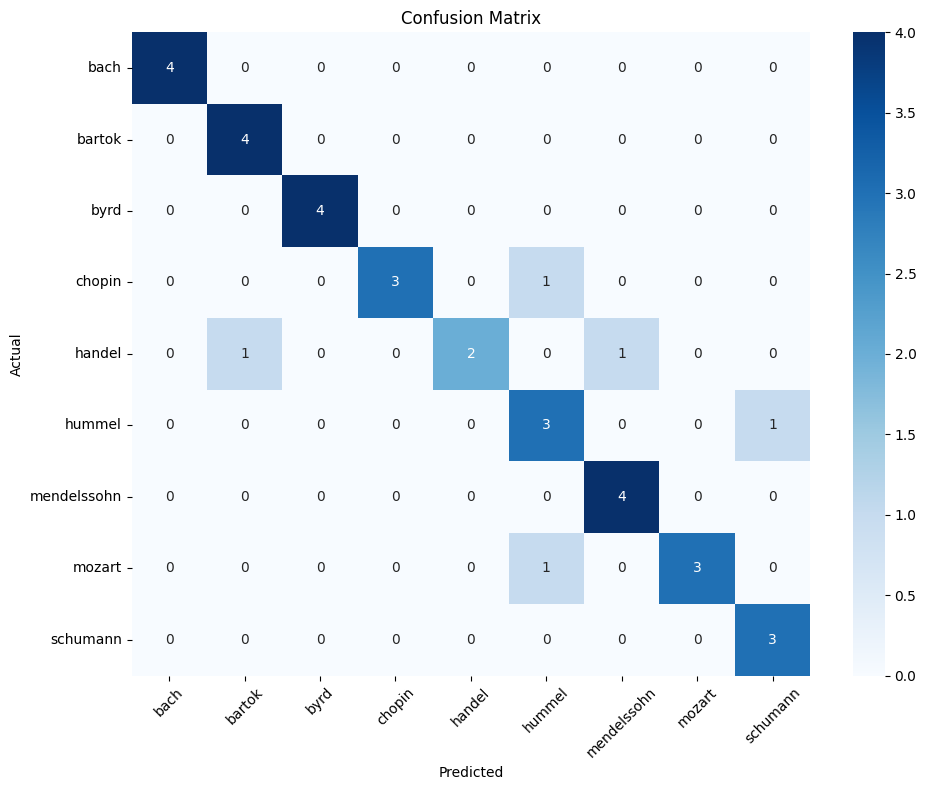

In [20]:
results = run_composer_classification_pipeline()

In [21]:
prediction_widget = predict_composer(
    results['model'], 
    'NN_midi_files_extended/test/chopin/chopin086.mid', 
    results['label_encoder'], 
    torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    results['player']
)

In [25]:
prediction_widget = predict_composer(
    results['model'], 
    'NN_midi_files_extended/test/schumann/schumann220.mid', 
    results['label_encoder'], 
    torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    results['player']
)

In [28]:
prediction_widget = predict_composer(
    results['model'], 
    'NN_midi_files_extended/test/handel/handel137.mid', 
    results['label_encoder'], 
    torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    results['player']
)

<Figure size 1500x1000 with 0 Axes>

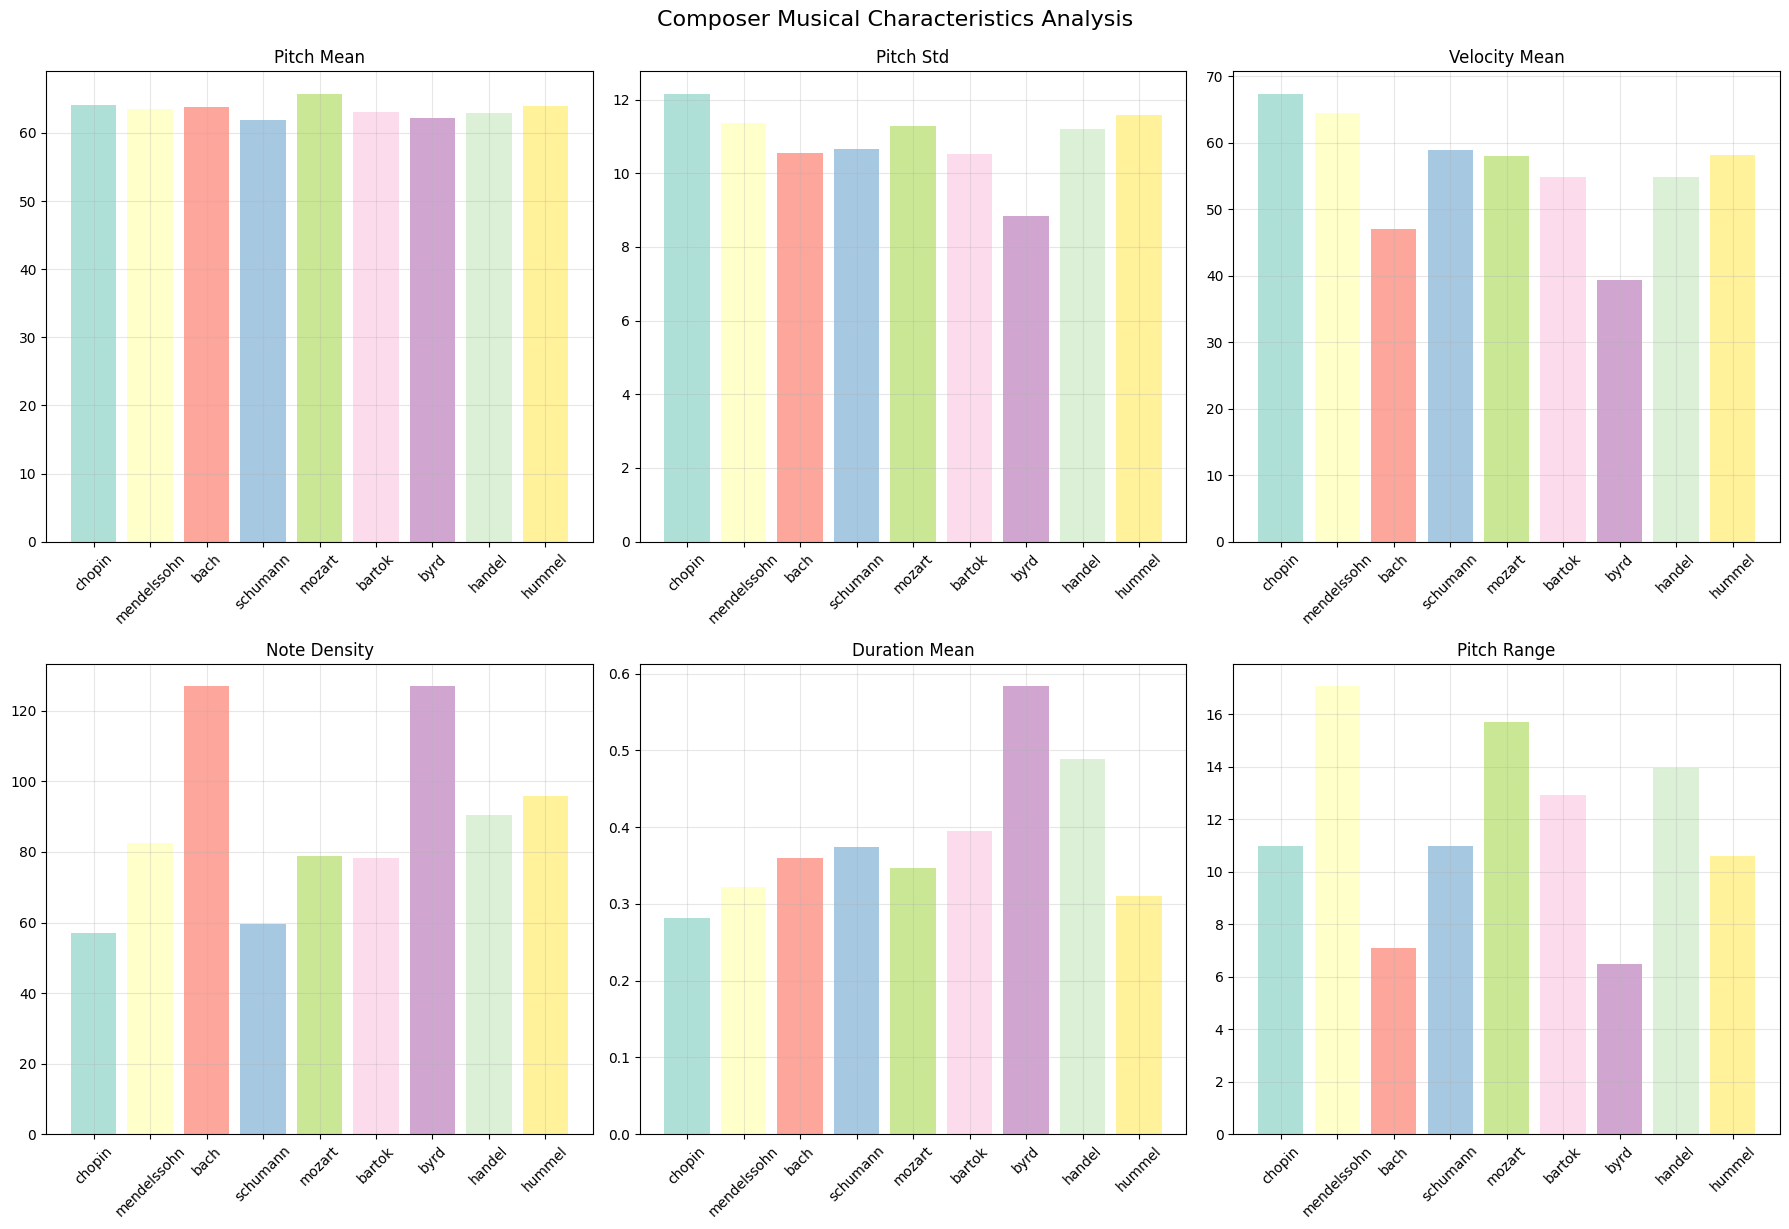

{'chopin': {'mean_features': array([6.4045151e+01, 1.2159139e+01, 6.7341461e+01, 6.4536583e+01,
         5.7055195e+01, 1.6393057e+01, 2.8170326e-01, 3.9012456e-01,
         3.7375942e-02, 2.2466376e-01, 2.7475568e+02, 1.0974830e+01,
         2.5441463e+02, 2.4580487e+02, 1.3675610e+02, 2.8534146e+02,
         1.8517073e+02, 2.2085365e+02, 1.9378049e+02, 1.9612195e+02,
         3.2104877e+02, 1.4695122e+02, 2.2004878e+02, 1.7978049e+02],
        dtype=float32),
  'std_features': array([3.5501504e+00, 2.1196797e+00, 1.0924592e+01, 4.2027745e+00,
         8.5278521e+00, 3.9813449e+00, 1.6226521e-01, 2.3795901e-01,
         1.6607039e-02, 6.1110903e-02, 3.2450824e+02, 4.8312364e+00,
         2.6754141e+02, 2.7188977e+02, 1.9416684e+02, 3.2936383e+02,
         2.1876944e+02, 2.6210989e+02, 2.4087743e+02, 2.4223428e+02,
         3.4204648e+02, 2.2027036e+02, 2.7616925e+02, 2.4566690e+02],
        dtype=float32),
  'num_samples': 287},
 'mendelssohn': {'mean_features': array([6.3575005e+01, 

In [29]:
analyze_composer_characteristics(results['model'], results['datasets'], results['label_encoder'], device)